In [3]:
import tensorflow as tf  # Core deep learning library  
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array  
from tensorflow.keras.applications import MobileNetV2  
from tensorflow.keras.models import Model, load_model  
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout  
from tensorflow.keras.optimizers import Adam  
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay  
import numpy as np  
import matplotlib.pyplot as plt  
import os  # File operations and paths  

In [7]:
train_dir = "dataset/train"  # Training data path  
val_dir = "dataset/validation"  # Validation data path  

train_datagen = ImageDataGenerator(  # Image augmentation for training  
    rescale=1./255,
    rotation_range=25,
    zoom_range=0.3,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)  # Only rescaling for validation  

train_data = train_datagen.flow_from_directory(  # Load and preprocess training images  
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_data = val_datagen.flow_from_directory(  # Load and preprocess validation images  
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

print("Detected classes:", train_data.class_indices)  # Display detected classes  

Found 20638 images belonging to 2 classes.
Found 20638 images belonging to 2 classes.
Detected classes: {'Diseased': 0, 'Healthy': 1}


In [9]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))  # Load base model  

base_model.trainable = False  # Freeze base layers  

x = base_model.output  # Base output  
x = GlobalAveragePooling2D()(x)  # Global pooling layer  
x = Dense(256, activation='relu')(x)  # Fully connected layer  
x = Dropout(0.3)(x)  # Dropout for regularization  
predictions = Dense(train_data.num_classes, activation='softmax')(x)  # Output layer  

model = Model(inputs=base_model.input, outputs=predictions)  # Build full model  

model.compile(optimizer=Adam(learning_rate=0.0001),  # Compile model  
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()  # Show model structure  

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,586,434 (9.87 MB)

 Trainable params: 328,450 (1.25 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [7]:
history = model.fit(  # Train the model  
    train_data,
    validation_data=val_data,
    epochs=10,
    verbose=1
)

C:\Users\arsen\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
645/645 ━━━━━━━━━━━━━━━━━━━━ 989s 2s/step - accuracy: 0.9363 - loss: 0.1559 - val_accuracy: 0.9660 - val_loss: 0.0892
Epoch 2/10
645/645 ━━━━━━━━━━━━━━━━━━━━ 840s 1s/step - accuracy: 0.9667 - loss: 0.0888 - val_accuracy: 0.9752 - val_loss: 0.0709
Epoch 3/10
645/645 ━━━━━━━━━━━━━━━━━━━━ 598s 928ms/step - accuracy: 0.9732 - loss: 0.0706 - val_accuracy: 0.9809 - val_loss: 0.0541
Epoch 4/10
645/645 ━━━━━━━━━━━━━━━━━━━━ 600s 930ms/step - accuracy: 0.9759 - loss: 0.0638 - val_accuracy: 0.9786 - val_loss: 0.0556
Epoch 5/10
645/645 ━━━━━━━━━━━━━━━━━━━━ 592s 918ms/step - accuracy: 0.9792 - loss: 0.0585 - val_accuracy: 0.9830 - val_loss: 0.0460
Epoch 6/10
645/645 ━━━━━━━━━━━━━━━━━━━━ 663s 1s/step - accuracy: 0.9793 - loss: 0.0548 - val_accuracy: 0.9819 - val_loss: 0.0491
Epoch 7/10
645/645 ━━━━━━━━━━━━━━━━━━━━ 624s 968ms/step - accuracy: 0.9795 - loss: 0.0549 - val_accuracy: 0.9852 - val_loss: 0.0420
Epoch 8/10
645/645 ━━━━━━━━━━━━━━━━━━━━ 627s 973ms/step - accuracy: 0.9815 - loss: 0.

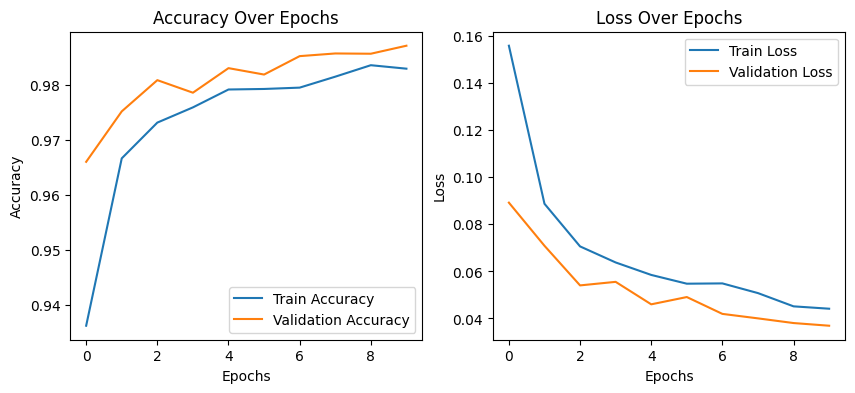

In [9]:
plt.figure(figsize=(10,4))  # Create a figure for plots  

plt.subplot(1,2,1)  # Accuracy subplot  
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')  # Title for accuracy graph  
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)  # Loss subplot  
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')  # Title for loss graph  
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()  # Display the plots  

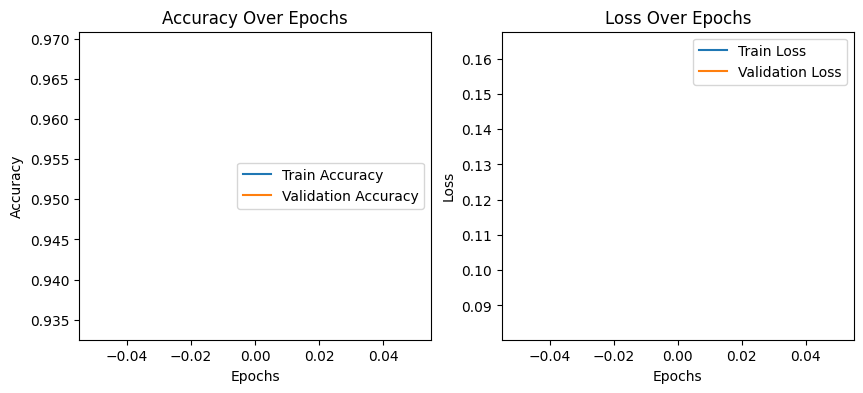

645/645 ━━━━━━━━━━━━━━━━━━━━ 256s 396ms/step - accuracy: 0.9691 - loss: 0.0843

Validation Accuracy: 96.91%
Validation Loss: 0.0843
645/645 ━━━━━━━━━━━━━━━━━━━━ 556s 862ms/step - accuracy: 0.9693 - loss: 0.0868

Training Accuracy: 96.93%
Training Loss: 0.0868
645/645 ━━━━━━━━━━━━━━━━━━━━ 266s 409ms/step
645/645 ━━━━━━━━━━━━━━━━━━━━ 378s 586ms/step

=== PERFORMANCE SUMMARY ===
Training Accuracy:  96.93%
Training F1-score:  0.7359
Validation Accuracy:96.91%
Validation F1-score:0.9691

=== Classification Report (Validation) ===
              precision    recall  f1-score   support

    Diseased       0.98      0.98      0.98     17417
     Healthy       0.90      0.90      0.90      3221

    accuracy                           0.97     20638
   macro avg       0.94      0.94      0.94     20638
weighted avg       0.97      0.97      0.97     20638



In [13]:
# === После обучения ===
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# === Evaluate on validation data ===
val_loss, val_acc = model.evaluate(val_data)
print(f"\nValidation Accuracy: {val_acc*100:.2f}%")
print(f"Validation Loss: {val_loss:.4f}")

# === Evaluate on training data ===
train_loss, train_acc = model.evaluate(train_data)
print(f"\nTraining Accuracy: {train_acc*100:.2f}%")
print(f"Training Loss: {train_loss:.4f}")

# === Compute F1-scores ===
from sklearn.metrics import classification_report, f1_score

# Validation predictions
val_preds = model.predict(val_data)
val_preds_classes = np.argmax(val_preds, axis=1)
true_val_classes = val_data.classes
class_labels = list(val_data.class_indices.keys())

train_preds = model.predict(train_data)
train_preds_classes = np.argmax(train_preds, axis=1)
true_train_classes = train_data.classes

# Validation F1
val_f1 = f1_score(true_val_classes, val_preds_classes, average='weighted')
# Training F1
train_f1 = f1_score(true_train_classes, train_preds_classes, average='weighted')

print("\n=== PERFORMANCE SUMMARY ===")
print(f"Training Accuracy:  {train_acc*100:.2f}%")
print(f"Training F1-score:  {train_f1:.4f}")
print(f"Validation Accuracy:{val_acc*100:.2f}%")
print(f"Validation F1-score:{val_f1:.4f}")

print("\n=== Classification Report (Validation) ===")
print(classification_report(true_val_classes, val_preds_classes, target_names=class_labels))


In [15]:
model.save("plant_disease_model.h5")
print("saved as plant_disease_model.h5")


saved as plant_disease_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


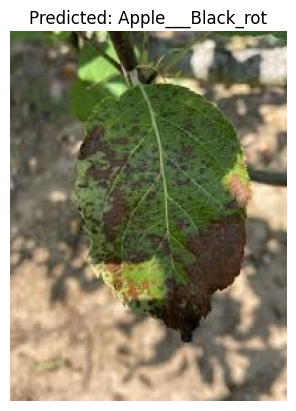

In [31]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

test_image_path = "images.jfif"  # Path to test image

if os.path.exists(test_image_path):  # Check if image exists
    img = load_img(test_image_path, target_size=(224, 224))
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)
    predicted_class = class_labels[np.argmax(prediction)]  # Predicted label

    plt.imshow(load_img(test_image_path))
    plt.title(f"Predicted: {predicted_class}")
    plt.axis('off')
    plt.show()
else:
    print("Error: image not found at", test_image_path)

In [29]:
class_labels = [  # List of plant disease class names  
    'Apple___Black_rot',
    'Apple___Scab',
    'Corn_(maize)___Cercospora_leaf_spot',
    'Corn_(maize)___Common_rust',
    'Grape___Black_rot',
    'Potato___Early_blight',
    'Potato___Late_blight',
    'Tomato___Bacterial_spot',
    'Tomato___Early_blight',
    'Tomato___Late_blight',
    'Tomato___Leaf_Mold',
    'Tomato___Septoria_leaf_spot',
    'Tomato___Target_Spot',
    'Tomato___Yellow_Leaf_Curl_Virus',
    'Tomato___healthy'
]

In [33]:
from sklearn.metrics import classification_report, f1_score

val_preds = model.predict(val_data)
val_preds_classes = np.argmax(val_preds, axis=1)
true_classes = val_data.classes
class_labels = list(val_data.class_indices.keys())

print("\nClassification Report:")
print(classification_report(true_classes, val_preds_classes, target_names=class_labels))

f1 = f1_score(true_classes, val_preds_classes, average='weighted')
print(f"\nWeighted F1 Score: {f1:.4f}")


645/645 ━━━━━━━━━━━━━━━━━━━━ 351s 542ms/step

Classification Report:
              precision    recall  f1-score   support

    Diseased       0.99      0.99      0.99     17417
     Healthy       0.95      0.96      0.96      3221

    accuracy                           0.99     20638
   macro avg       0.97      0.98      0.98     20638
weighted avg       0.99      0.99      0.99     20638


Weighted F1 Score: 0.9871


645/645 ━━━━━━━━━━━━━━━━━━━━ 281s 436ms/step

Classification Report:
              precision    recall  f1-score   support

    Diseased       0.99      0.99      0.99     17417
     Healthy       0.95      0.96      0.96      3221

    accuracy                           0.99     20638
   macro avg       0.97      0.98      0.98     20638
weighted avg       0.99      0.99      0.99     20638



<Figure size 1000x1000 with 0 Axes>

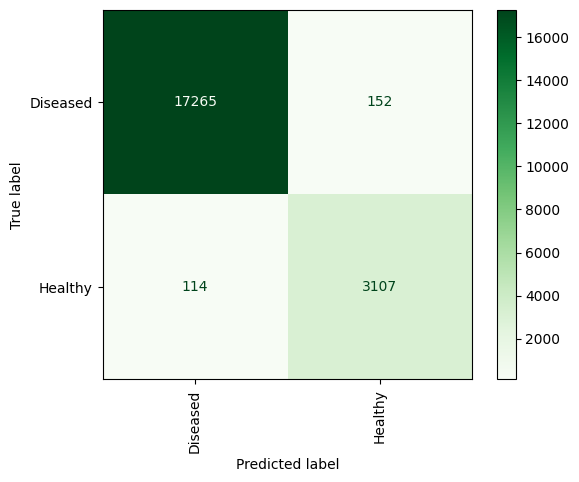

In [35]:
# Generate predictions
y_pred = model.predict(val_data)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = val_data.classes
class_labels = list(val_data.class_indices.keys())

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
plt.figure(figsize=(10,10))
disp.plot(cmap='Greens', xticks_rotation=90)
plt.show()